Ce notebook est un "brouillon" pour tenter d'améliorer le modèle. (globalement je vais faire ça comme un gros sagouin)

on va se concentrer que sur un jeu de données, on se fiche un peu de la méthode d'imputation, la différence est probablement négligeable. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

# Importation des modules utilitaires avec la nouvelle structure
from utils.data_registry import DATASETS
from utils.benchmarks import get_models
from utils.data_loading import load_datasets
from utils.data_preprocessing import normalize_rendements_by_row
from utils.feature_engineering import add_features, add_financial_features
from utils.experiment_runner import run_experiment, display_experiment_result, add_result
from utils.data_analysis import (
    analyze_distributions, 
    compare_column_stats, 
    analyze_normalization,
    analyze_normalized_dataset,
    compare_normalization_impact,
    perform_pca_analysis,
    analyze_correlations
)
from utils.feature_selection import (
    select_by_correlation,
    select_by_f_value,
    select_by_mutual_info, 
    compare_feature_selection_methods,
    optimize_feature_count,
    find_important_features
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from tqdm import tqdm


In [ ]:
# SI UNE FONCTIONNE IMPORTEE BUG, ON PEUT RECHARGER LE MODULE COMME SUIVANT 
import sys
import importlib

# Forcer le rechargement en supprimant le module du cache
if 'utils.data_analysis' in sys.modules:
    del sys.modules['utils.data_analysis']

# Réimporter le module
from utils.data_analysis import compare_column_stats

In [16]:

# Create empty results tracker
results_tracker = pd.DataFrame(columns=[
    "dataset", "dataset_description", "model", "model_description", 
    "features_added", "feature_sets", "accuracy", "precision_weighted", 
    "recall_weighted", "f1_weighted"
])


In [3]:

# =========================================
# Section 1: Chargement des données
# =========================================
print("Chargement des données...")

# 1.1 Chargement du dataset brut pour référence
X_train_70 = pd.read_csv(r"processed_data\X_train_70.csv")
X_test_70 = pd.read_csv(r"processed_data\X_test_70.csv")

print("\n--- Aperçu des données d'entraînement de référence ---")
print(f"Nombre de lignes train: {X_train_70.shape[0]}, Nombre de colonnes: {X_train_70.shape[1]}")
print(f"Nombre de lignes test: {X_test_70.shape[0]}, Nombre de colonnes: {X_test_70.shape[1]}")

Chargement des données...

--- Aperçu des données d'entraînement de référence ---
Nombre de lignes train: 730784, Nombre de colonnes: 57
Nombre de lignes test: 857641, Nombre de colonnes: 57


In [4]:
X_train = pd.read_csv(r"input_training.csv")
X_test = pd.read_csv(r"input_test.csv")

In [ ]:
X_train

,ID,day,equity,r0,r1,r2,r3,r4,r5,r6,...,r43,r44,r45,r46,r47,r48,r49,r50,r51,r52
0,0,249,1488,0.00,NaN,NaN,NaN,0.00,NaN,NaN,...,0.00,0.00,NaN,0.00,NaN,0.00,NaN,NaN,NaN,0.00
1,1,272,107,-9.76,0.00,-12.21,46.44,34.08,0.00,41.24,...,-4.83,-16.92,-4.84,4.84,0.00,7.26,-9.68,-19.38,9.71,26.68
2,2,323,1063,49.85,0.00,0.00,-26.64,-23.66,-22.14,49.12,...,-6.37,1.59,6.37,-49.32,-9.59,-6.40,22.41,-6.39,7.99,15.96
3,3,302,513,0.00,NaN,0.00,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN
4,4,123,1465,-123.84,-115.18,-26.44,0.00,42.42,10.56,0.00,...,-5.36,-21.44,-21.48,10.78,-21.55,-5.40,-10.81,5.41,-32.47,43.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843294,843294,297,123,3.96,0.00,-70.34,74.24,-0.56,0.00,-23.63,...,-10.80,1.71,0.00,-3.98,2.28,-21.62,-1.71,9.12,0.00,9.11
843295,843295,16,1501,0.00,-183.49,-13.19,46.24,0.00,-39.60,13.25,...,0.00,6.62,0.00,19.85,0.00,-26.42,6.62,0.00,0.00,-19.88
843296,843296,166,1231,37.02,2.93,-3.67,16.89,-4.03,13.56,-4.39,...,2.92,-3.28,-1.46,-3.65,-1.10,-13.51,2.92,-6.21,9.69,-3.66
843297,843297,297,747,34.45,15.10,-35.61,19.25,-16.46,-26.12,20.68,...,-20.65,-5.52,-6.90,9.67,1.38,6.90,-11.04,33.16,13.77,12.38


In [34]:
y_train = pd.read_csv(r"output\output_training_gmEd6Zt.csv")
y_train

,ID,reod
0,0,0
1,1,0
2,2,-1
3,3,0
4,4,-1
...,...,...
843294,843294,1
843295,843295,-1
843296,843296,0
843297,843297,1


In [40]:
!pip install signax

In [81]:
import signax
px = X_train[[c for c in X_train.columns if c not in ["ID", "day", "equity"]]].fillna(0).cumsum(axis=1).values
px_lead_lad = np.concatenate([px[:,1:,None], px[:,:-1, None]], axis=2)
sig = signax.signature(px_lead_lad, depth=2, stream=True)
x_train = np.concatenate([
    sig[:,-1],
],axis=1)


In [74]:
x_train.shape, X_train[[c for c in X_train.columns if c not in ["ID", "day", "equity"]]].isna().sum(axis=1).values[:,None].shape

((843299, 30), (843299, 1))

In [75]:

x_train = np.concatenate([x_train, X_train[[c for c in X_train.columns if c not in ["ID", "day", "equity"]]].isna().sum(axis=1).values[:,None]], axis=1)


In [82]:
import xgboost as xgb

model = xgb.XGBClassifier(
    n_estimators = 300,
    learning_rate =0.1, 
    max_depth = 4,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
)

val_split = int(0.8*len(X_train))

model.fit(x_train[:],y_train.values[:,-1]+1, verbose=True)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [83]:
import signax
px_test = X_test[[c for c in X_test.columns if c not in ["ID", "day", "equity"]]].fillna(0).cumsum(axis=1).values
px_lead_lad = np.concatenate([px_test[:,1:,None], px_test[:,:-1, None]], axis=2)
sig = signax.signature(px_lead_lad, depth=2, stream=True)
x_test = np.concatenate([
    sig[:,-1],
], axis=1)


In [62]:
x_test.shape, X_test.shape

((885799, 71), (885799, 56))

In [78]:
x_test = np.concatenate([x_test, X_test[[c for c in X_test.columns if c not in ["ID", "day", "equity"]]].isna().sum(axis=1).values[:,None]], axis=1)


In [79]:
model.predict(x_test)

array([0, 2, 0, ..., 1, 1, 1], shape=(885799,))

In [64]:
y_test = pd.read_csv(r"output\output_test_random.csv").values

In [84]:
accuracy = accuracy_score(y_test[:,-1], model.predict(x_test)-1)
accuracy

0.33885904138523526

In [71]:
np.sum(model.predict(x_test)==0)/len(y_test)

np.float64(0.4312276261318877)

In [69]:
np.sum(y_test[:,-1]==0)/len(y_test)

np.float64(0.4107771627649162)

In [5]:
# 1.2 Chargement du dataset principal (ffbf)
x_train_ffbf = pd.read_csv(r"processed_data\X_train_ffbf.csv")
x_test_ffbf = pd.read_csv(r'processed_data\X_test_ffbf.csv')

# Séparation des features et de la cible
y_train_ffbf = x_train_ffbf["reod"].copy()
y_test_ffbf = x_test_ffbf["reod"].copy()

# Conservation uniquement des colonnes pertinentes
x_train_ffbf = x_train_ffbf.loc[:,"ID":"r52"]
x_test_ffbf = x_test_ffbf.loc[:,"ID":"r52"]

print("\n--- Aperçu des données d'entraînement ffbf ---")
print(f"Nombre de lignes train: {x_train_ffbf.shape[0]}, Nombre de colonnes: {x_train_ffbf.shape[1]}")
print(f"Nombre de lignes test: {x_test_ffbf.shape[0]}, Nombre de colonnes: {x_test_ffbf.shape[1]}")



--- Aperçu des données d'entraînement ffbf ---
Nombre de lignes train: 730784, Nombre de colonnes: 56
Nombre de lignes test: 857641, Nombre de colonnes: 56


In [6]:

# 1.3 Chargement du dataset avec features préprocessées
x_train_ffbf_with_feature = pd.read_csv(r"processed_data\preprocessed\X_train_ffbf_with_features.csv")
x_test_ffbf_with_feature = pd.read_csv(r'processed_data\preprocessed\X_test_ffbf_with_features.csv')

y_train_ffbf_with_features = x_train_ffbf_with_feature["reod"].copy()
y_test_ffbf_with_features = x_test_ffbf_with_feature["reod"].copy()

# Vérification des données manquantes
train_na_count = x_train_ffbf_with_feature.isna().sum().sum()
test_na_count = x_test_ffbf_with_feature.isna().sum().sum()

print("\n--- Aperçu des données d'entraînement avec features ---")
print(f"Nombre de lignes train: {x_train_ffbf_with_feature.shape[0]}, Nombre de colonnes: {x_train_ffbf_with_feature.shape[1]}")
print(f"Nombre de lignes test: {x_test_ffbf_with_feature.shape[0]}, Nombre de colonnes: {x_test_ffbf_with_feature.shape[1]}")
print(f"\nNombre de NA train: {train_na_count}")
print(f"Nombre de NA test: {test_na_count}")



--- Aperçu des données d'entraînement avec features ---
Nombre de lignes train: 730784, Nombre de colonnes: 75
Nombre de lignes test: 857641, Nombre de colonnes: 75

Nombre de NA train: 0
Nombre de NA test: 0


In [6]:

# Afficher les datasets et modèles disponibles
print("\nDatasets disponibles:")
for key, info in DATASETS.items():
    print(f"- {key}: {info['description']}")

print("\nModèles disponibles:")
models = get_models()
for key, info in models.items():
    if 'description' in info:
        print(f"- {key}: {info['description']}")
    else:
        print(f"- {key}")



Datasets disponibles:
- raw: Données brutes
- ffbf: Données forward filled puis backward
- bfff: Données backward filled puis forward
- interp: Données interpolation linéaire puis bffff
- mice: Données MICE imputer puis bfff
- knn: Données knn imputer puis bfff
- raw_with_features: Données brutes avec features
- ffbf_with_features: Données forward filled puis backward avec features
- bfff_with_features: Données backward filled puis forward avec features
- interp_with_features: Données interpolation linéaire puis bffff avec features
- mice_with_features: Données MICE imputer puis bfff avec features
- knn_with_features: Données knn imputer puis bfff avec features

Modèles disponibles:
- xgboost_baseline: XGBoost de base
- xgboost_tuned: XGBoost avec paramètres 
- rf_baseline: Baseline Random Forest model
- logistic: Multinomial Logistic Regression


In [ ]:

# =========================================
# Section 2: Modèles de Référence
# =========================================
print("\n\n--- Comparaison des stratégies d'imputation avec XGBoost ---")

# 2.1 Test des performances du modèle de base
imputation_strategies = ["ffbf"]
imputation_results = []
scalers = {
    'Standard': StandardScaler(),
    'MinMax': MinMaxScaler(),
    'Robust': RobustScaler(),
    'Quantile': QuantileTransformer(output_distribution='normal')
}

# 2.2 Test avec différents scalers sans feature engineering
for strategy in imputation_strategies:
    for scaler_name, scaler in scalers.items():
        print(f"\n Using {scaler} - Testing normalisation on {strategy}...")
        print(f"\nTesting {strategy} imputation...")
        try:
            result_without_features = run_experiment(
                dataset_key=strategy, 
                model_key="xgboost_baseline", 
                add_feat=False, 
                scaler=scaler
            )
            results_tracker = add_result(results_tracker, result_without_features)
            imputation_results.append(result_without_features)
            print(f"Accuracy without feature engineering: {result_without_features['accuracy']:.4f}")
        except Exception as e:
            print(f"Error processing standard {strategy} dataset: {e}")

# 2.3 Test avec features préprocessées sans normalisation 
for strategy in imputation_strategies:
    print(f"\nTesting {strategy} with precomputed features...")
    for scaler_name, scaler in scalers.items():
        print(f"\n Using {scaler} - Testing normalisation on {strategy} with precomputed features...")
        try:
            preprocessed_key = f"{strategy}_with_features"
            
            if preprocessed_key in DATASETS:
                result_with_features = run_experiment(
                    dataset_key=preprocessed_key, 
                    model_key="xgboost_baseline", 
                    add_feat=False, 
                    scaler=scaler
                )
                results_tracker = add_result(results_tracker, result_with_features)
                imputation_results.append(result_with_features)
                print(f"Accuracy with precomputed features: {result_with_features['accuracy']:.4f}")
                
                standard_result = next((r for r in imputation_results if r['dataset'] == strategy), None)
                if standard_result:
                    improvement = result_with_features['accuracy'] - standard_result['accuracy']
                    print(f"Improvement from feature engineering: {improvement:.4f} ({improvement*100:.2f}%)")
            else:
                print(f"Preprocessed dataset '{preprocessed_key}' not found in registry.")
        except Exception as e:
            print(f"Error processing preprocessed {strategy} dataset: {e}")

# 2.4 Test avec normalisation par ligne des features préprocessées
print("\n--- Testing with row normalization ---")
for strategy in imputation_strategies:
    for scaler_name, scaler in scalers.items():
        print(f"\n Using {scaler} - Testing normalisation on {strategy} with precomputed features...")
        preprocessed_key = f"{strategy}_with_features"
        if preprocessed_key in DATASETS:
            try:
                print(f"\nTesting normalisation on {strategy} with precomputed features...")
                result_normalized = run_experiment(
                    dataset_key=preprocessed_key, 
                    model_key="xgboost_baseline", 
                    add_feat=False,
                    normalize_by_row=True,
                    scaler=scaler
                )
                results_tracker = add_result(results_tracker, result_normalized)
                imputation_results.append(result_normalized)
                print(f"{strategy} with row normalization: Accuracy = {result_normalized['accuracy']:.4f}")
                
                non_normalized = next((r for r in imputation_results if r['dataset'] == preprocessed_key and not r.get('normalize_by_row', False)), None)
                if non_normalized:
                    diff = result_normalized['accuracy'] - non_normalized['accuracy']
                    print(f"Impact of row normalization: {diff:.4f} ({diff*100:.2f}%)")
            except Exception as e:
                print(f"Error with row normalization on {strategy}: {e}")




--- Comparaison des stratégies d'imputation avec XGBoost ---

 Using StandardScaler() - Testing normalisation on ffbf...

Testing ffbf imputation...
Aucune valeur manquante détectée.


c:\Users\julie\Documents\Python\Machine Learning - Projet FInal\utils\experiment_runner.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([results_tracker, pd.DataFrame([result])], ignore_index=True)


Accuracy without feature engineering: 0.3136

 Using MinMaxScaler() - Testing normalisation on ffbf...

Testing ffbf imputation...
Aucune valeur manquante détectée.
Accuracy without feature engineering: 0.3136

 Using RobustScaler() - Testing normalisation on ffbf...

Testing ffbf imputation...
Aucune valeur manquante détectée.
Accuracy without feature engineering: 0.3136

 Using QuantileTransformer(output_distribution='normal') - Testing normalisation on ffbf...

Testing ffbf imputation...
Aucune valeur manquante détectée.
Accuracy without feature engineering: 0.3143

Testing ffbf with precomputed features...

 Using StandardScaler() - Testing normalisation on ffbf with precomputed features...
Aucune valeur manquante détectée.
Accuracy with precomputed features: 0.3088
Improvement from feature engineering: -0.0048 (-0.48%)

 Using MinMaxScaler() - Testing normalisation on ffbf with precomputed features...
Aucune valeur manquante détectée.
Accuracy with precomputed features: 0.3080
Imp



--- Analyse des données normalisées ---
Analyse des distributions de 53 colonnes de rendement après normalisation


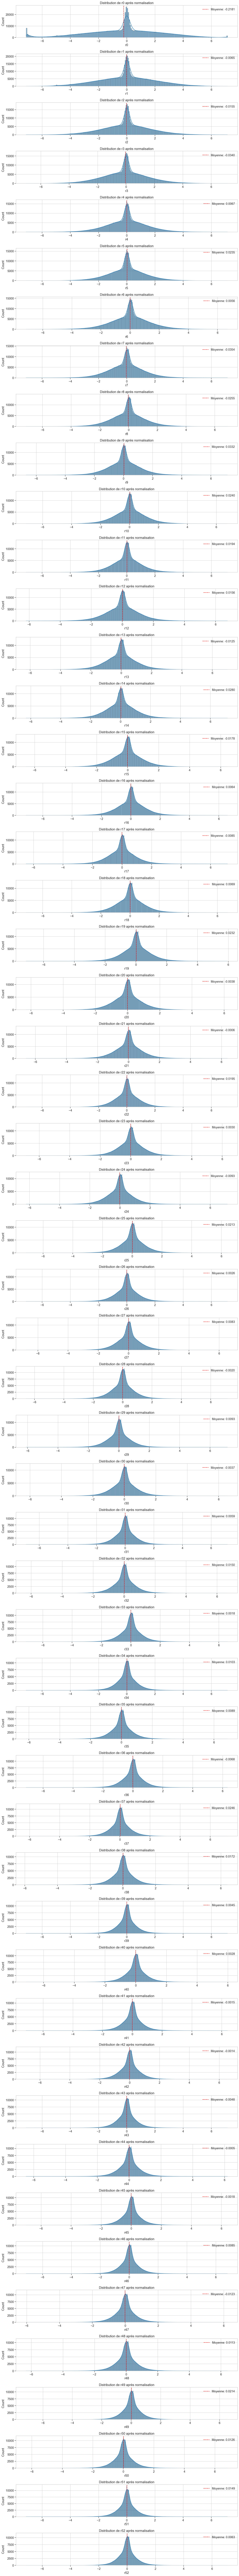

In [7]:
# =========================================
# Section 3: Analyse des données normalisées
# =========================================
print("\n\n--- Analyse des données normalisées ---")

# 3.1 Application de la normalisation par ligne
x_train_ffbf_with_feature_normalized = normalize_rendements_by_row(x_train_ffbf_with_feature)

# 3.2 Analyse des distributions après normalisation
rendement_cols = [col for col in x_train_ffbf_with_feature_normalized.columns if col.startswith('r') and col[1:].isdigit()]
sample_cols = ['r0', 'r10', 'r25', 'r40', 'r52']

height_per_subplot = 3 
total_height = height_per_subplot * len(rendement_cols) 

print(f"Analyse des distributions de {len(rendement_cols)} colonnes de rendement après normalisation")
plt.figure(figsize=(15, total_height))
for i, col in enumerate(rendement_cols):
    plt.subplot(len(rendement_cols), 1, i+1)
    sns.histplot(x_train_ffbf_with_feature_normalized[col], kde=True)
    plt.title(f'Distribution de {col} après normalisation')
    plt.axvline(x_train_ffbf_with_feature_normalized[col].mean(), color='r', linestyle='--', 
                label=f'Moyenne: {x_train_ffbf_with_feature_normalized[col].mean():.4f}')
    plt.legend()
plt.tight_layout()
plt.show()



Comparaison des données avant et après normalisation:


MemoryError: Unable to allocate 2.57 GiB for an array with shape (345145061,) and data type float64

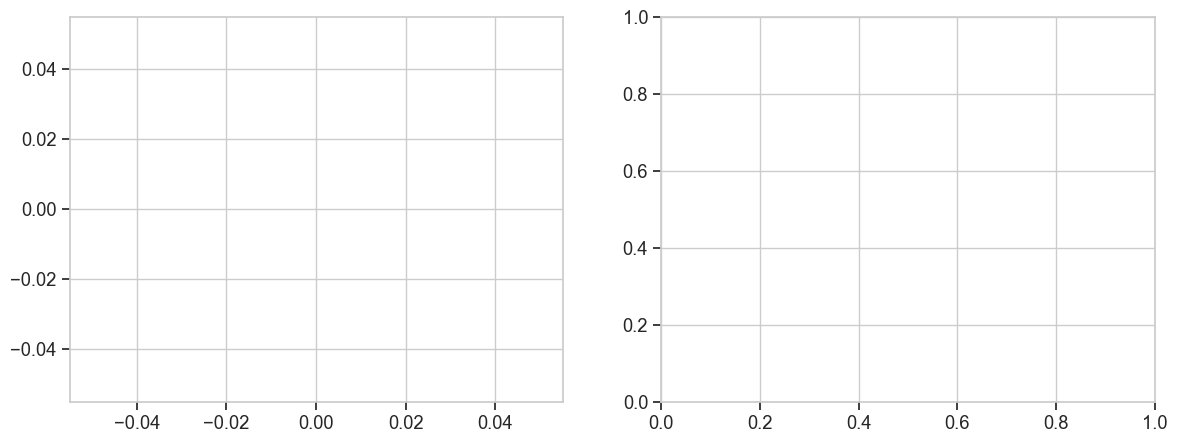

In [ ]:
#A lancer si la mémoire le permet
# 3.3 Comparaison avant/après normalisation
print("\nComparaison des données avant et après normalisation:")
compare_normalization_impact(
    x_train_ffbf_with_feature, 
    x_train_ffbf_with_feature_normalized, 
    sample_cols=sample_cols
)




--- Sélection des Features Importantes ---

Méthode 1: Sélection par corrélation


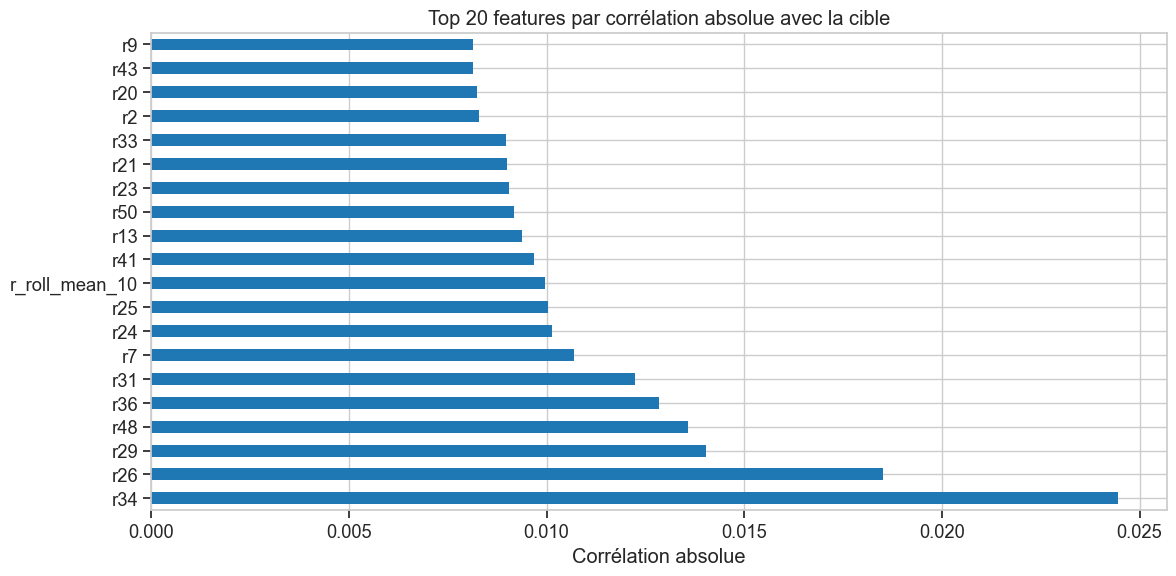

Top corrélations positives:
r34    0.024467
r29    0.014039
r36    0.012853
r31    0.012236
r25    0.010041
r41    0.009689
r13    0.009377
r23    0.009037
r21    0.008986
r40    0.007778
dtype: float64

Top corrélations négatives:
r26              -0.018521
r48              -0.013567
r7               -0.010698
r24              -0.010136
r_roll_mean_10   -0.009969
r50              -0.009167
r33              -0.008980
r2               -0.008278
r20              -0.008230
r43              -0.008147
dtype: float64

Méthode 2: Sélection par test ANOVA (F-value)


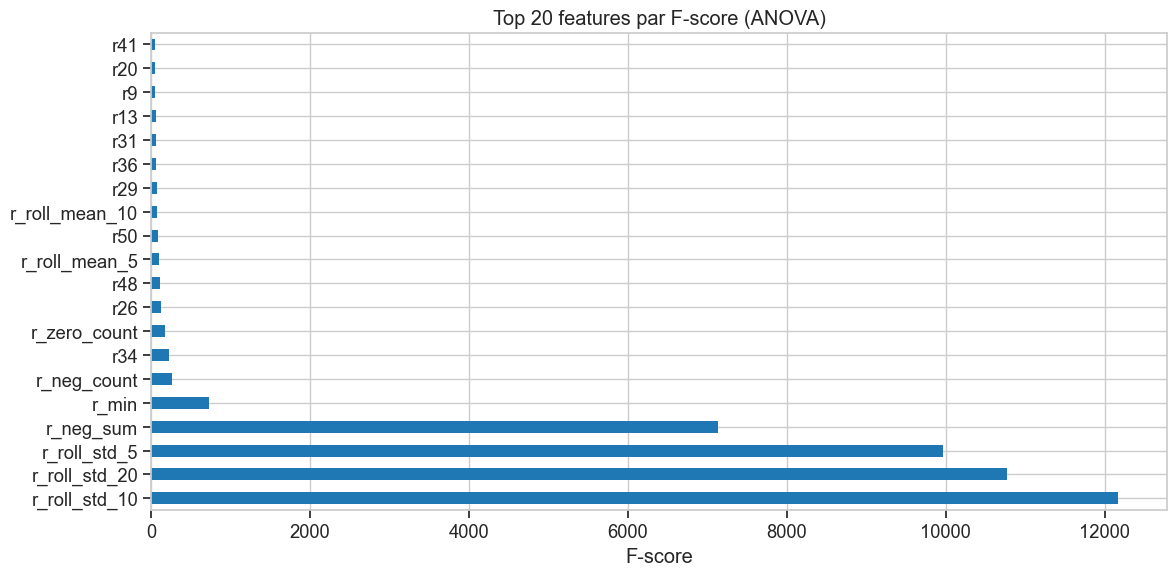

Top features par F-score avec leurs p-values:
r_roll_std_10: F-score = 12174.74, p-value = 0.000000
r_roll_std_20: F-score = 10771.57, p-value = 0.000000
r_roll_std_5: F-score = 9965.06, p-value = 0.000000
r_neg_sum: F-score = 7127.80, p-value = 0.000000
r_min: F-score = 724.36, p-value = 0.000000
r_neg_count: F-score = 258.94, p-value = 0.000000
r34: F-score = 218.87, p-value = 0.000000
r_zero_count: F-score = 175.45, p-value = 0.000000
r26: F-score = 126.17, p-value = 0.000000
r48: F-score = 105.70, p-value = 0.000000

Méthode 3: Sélection par information mutuelle


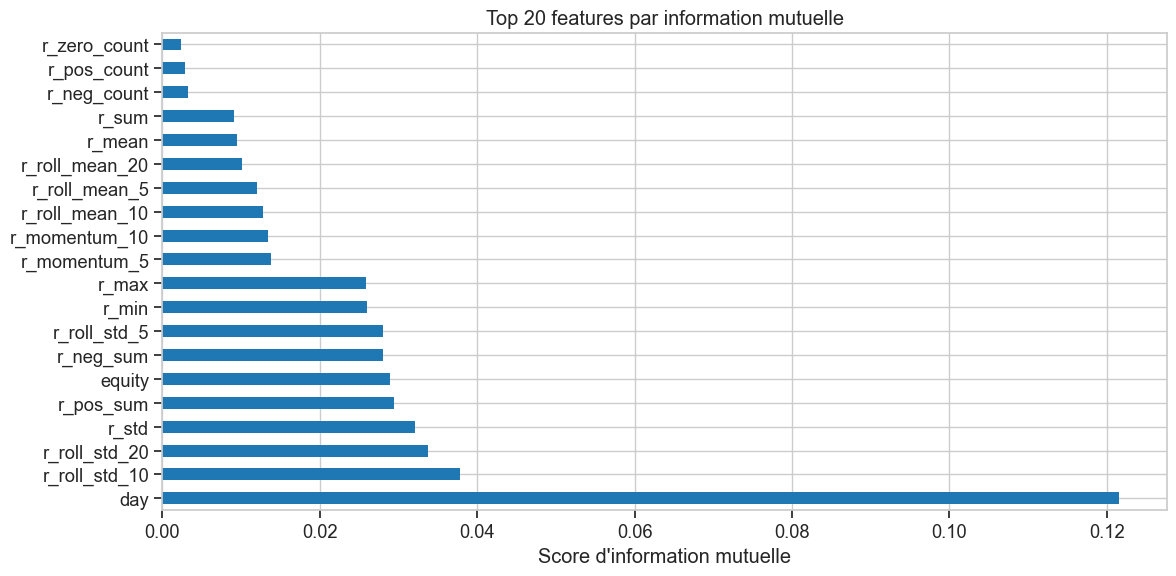

Top features par information mutuelle:
day              0.121561
r_roll_std_10    0.037786
r_roll_std_20    0.033737
r_std            0.032063
r_pos_sum        0.029458
equity           0.028887
r_neg_sum        0.028073
r_roll_std_5     0.028037
r_min            0.026026
r_max            0.025925
dtype: float64

Comparaison des méthodes de sélection:
Comparaison des top 20 features par méthode:
       correlation         f_value     mutual_info
0              r34   r_roll_std_10             day
1              r26   r_roll_std_20   r_roll_std_10
2              r29    r_roll_std_5   r_roll_std_20
3              r48       r_neg_sum           r_std
4              r36           r_min       r_pos_sum
5              r31     r_neg_count          equity
6               r7             r34       r_neg_sum
7              r24    r_zero_count    r_roll_std_5
8              r25             r26           r_min
9   r_roll_mean_10             r48           r_max
10             r41   r_roll_mean_5    r_

c:\Users\julie\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib_venn\layout\venn3\pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


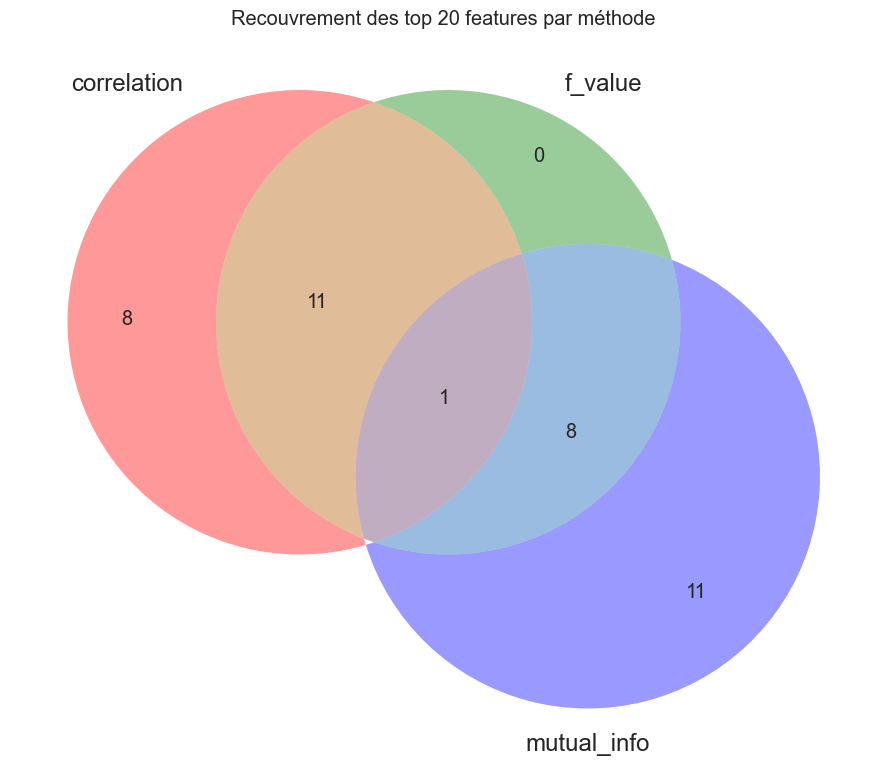


Recouvrement entre correlation et f_value: 12 features (60.0%)

Recouvrement entre correlation et mutual_info: 1 features (5.0%)

Recouvrement entre f_value et mutual_info: 9 features (45.0%)

Features communes aux 3 méthodes (top 20): 1
['r_roll_mean_10']

Nombre de features uniques dans l'union des top 10 de chaque méthode: 22
['day', 'equity', 'r24', 'r25', 'r26', 'r29', 'r31', 'r34', 'r36', 'r48', 'r7', 'r_max', 'r_min', 'r_neg_count', 'r_neg_sum', 'r_pos_sum', 'r_roll_mean_10', 'r_roll_std_10', 'r_roll_std_20', 'r_roll_std_5', 'r_std', 'r_zero_count']


In [8]:

# =========================================
# Section 4: Sélection des Features
# =========================================
print("\n\n--- Sélection des Features Importantes ---")

# 4.1 Préparation des données pour l'analyse
X = x_train_ffbf_with_feature_normalized.drop(['ID', 'reod'], axis=1, errors='ignore')
y = y_train_ffbf_with_features

# 4.2 Utilisation de différentes méthodes de sélection
print("\nMéthode 1: Sélection par corrélation")
corr_results = select_by_correlation(X, y, top_n=50)

print("\nMéthode 2: Sélection par test ANOVA (F-value)")
f_results = select_by_f_value(X, y, top_n=50)

print("\nMéthode 3: Sélection par information mutuelle")
mi_results = select_by_mutual_info(X, y, top_n=50)

# 4.3 Comparaison des résultats des différentes méthodes
all_results = {
    'correlation': corr_results,
    'f_value': f_results,
    'mutual_info': mi_results
}
print("\nComparaison des méthodes de sélection:")
compare_feature_selection_methods(all_results, top_n=20)

# 4.4 Identification des features communes à toutes les méthodes
common_features = set(corr_results['selected_features'][:20]) & \
                 set(f_results['selected_features'][:20]) & \
                 set(mi_results['selected_features'][:20])
print(f"\nFeatures communes aux 3 méthodes (top 20): {len(common_features)}")
print(sorted(list(common_features)))

# 4.5 Création d'un ensemble d'union des top features
union_features = set()
for method_results in all_results.values():
    union_features.update(method_results['selected_features'][:10])
print(f"\nNombre de features uniques dans l'union des top 10 de chaque méthode: {len(union_features)}")
print(sorted(list(union_features)))


Classes originales: [np.int64(-1), np.int64(0), np.int64(1)]
Classes remappées: [np.int64(0), np.int64(1), np.int64(2)]

Optimisation pour la méthode: correlation


100%|██████████| 9/9 [06:09<00:00, 41.10s/it]

Nombre optimal de features: 45
Score de validation croisée: 0.4488 ± 0.0012


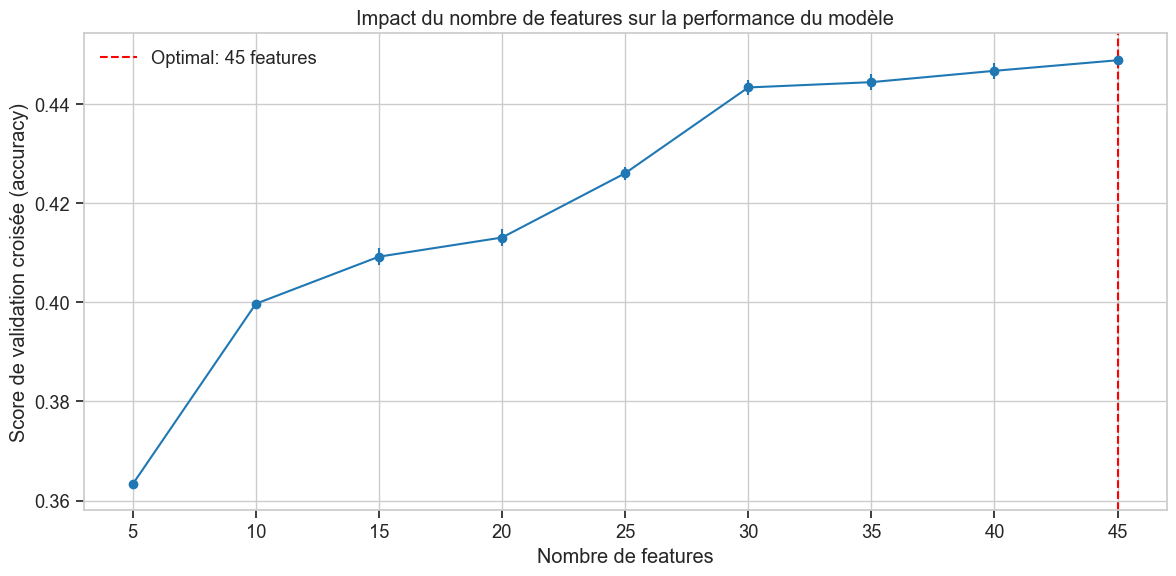

Méthode correlation - Nombre optimal de features: 45
Score avec features optimales: 0.4488

Optimisation pour la méthode: f_value


100%|██████████| 9/9 [05:47<00:00, 38.60s/it]

Nombre optimal de features: 45
Score de validation croisée: 0.5071 ± 0.0009


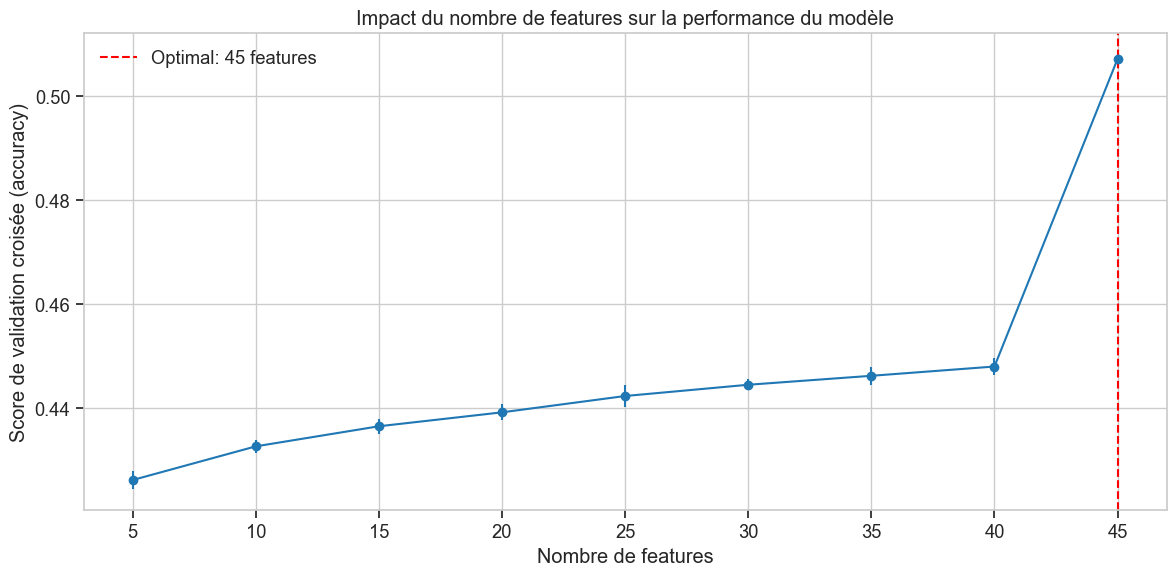

Méthode f_value - Nombre optimal de features: 45
Score avec features optimales: 0.5071

Optimisation pour la méthode: mutual_info


100%|██████████| 9/9 [05:46<00:00, 38.55s/it]

Nombre optimal de features: 45
Score de validation croisée: 0.5084 ± 0.0014


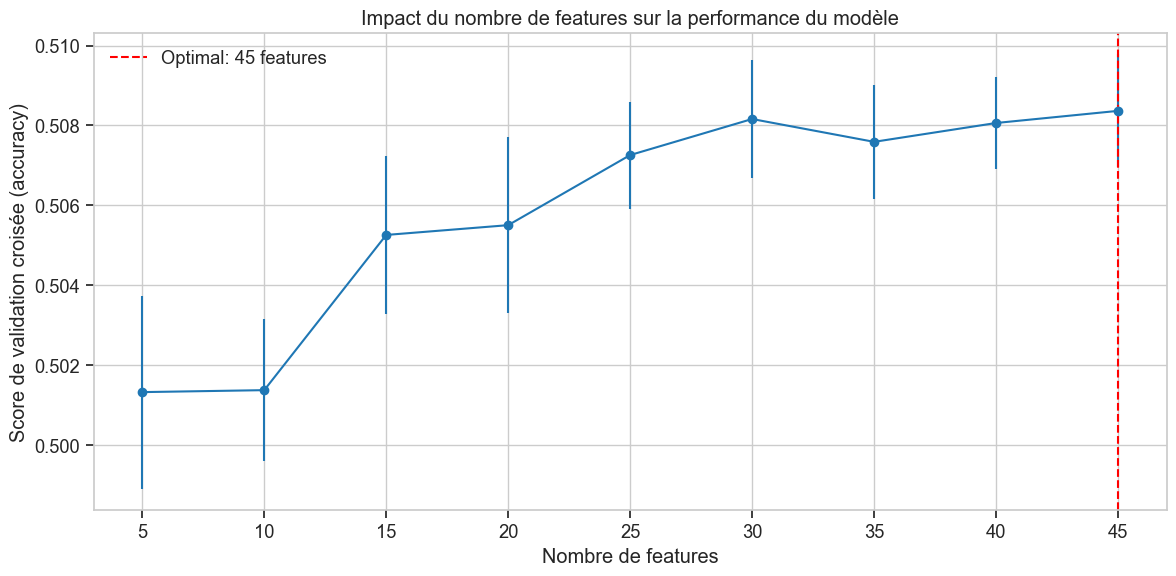

Méthode mutual_info - Nombre optimal de features: 45
Score avec features optimales: 0.5084


In [9]:
# 5.1 Définition d'une factory function pour XGBoost avec remappage des classes
def xgboost_factory():
    return XGBClassifier(
        objective="multi:softmax",
        num_class=3,
        n_estimators=100,
        random_state=42
    )

# Remappage des classes pour XGBoost
mapping = {-1: 0, 0: 1, 1: 2}
y_mapped = y.map(mapping)

print(f"Classes originales: {sorted(y.unique())}")
print(f"Classes remappées: {sorted(y_mapped.unique())}")

# 5.2 Optimisation pour chaque méthode de sélection
for method_name, results in all_results.items():
    print(f"\nOptimisation pour la méthode: {method_name}")
    try:
        feature_ranking = results['selected_features']
        
        optimization_result = optimize_feature_count(
            X, y_mapped,  # Utiliser y_mapped au lieu de y
            model_factory=xgboost_factory,
            feature_ranking=feature_ranking,
            n_features_range=range(5, min(101, len(feature_ranking)), 5)
        )
        
        # Sauvegarder les features optimales pour chaque méthode
        all_results[method_name]['optimal_features'] = optimization_result['optimal_features']
        all_results[method_name]['optimal_n_features'] = optimization_result['optimal_n_features']
        all_results[method_name]['best_score'] = optimization_result['best_score']
        
        print(f"Méthode {method_name} - Nombre optimal de features: {optimization_result['optimal_n_features']}")
        print(f"Score avec features optimales: {optimization_result['best_score']:.4f}")
        
    except Exception as e:
        print(f"Erreur lors de l'optimisation pour {method_name}: {e}")



--- Évaluation finale des modèles avec features optimisées ---

La meilleure méthode de sélection est: mutual_info avec un score de 0.5084
Nombre de features optimales: 45
Top 10 des features optimales:
['day', 'r_roll_std_10', 'r_roll_std_20', 'r_std', 'r_pos_sum', 'equity', 'r_neg_sum', 'r_roll_std_5', 'r_min', 'r_max']

Entraînement du modèle final avec les features optimales...

Performance finale sur le dataset de test:
Accuracy: 0.3088

Classification Report:
              precision    recall  f1-score   support

          -1       0.30      0.10      0.15    257874
           0       0.41      0.15      0.22    352296
           1       0.29      0.75      0.42    247471

    accuracy                           0.31    857641
   macro avg       0.33      0.33      0.26    857641
weighted avg       0.34      0.31      0.26    857641



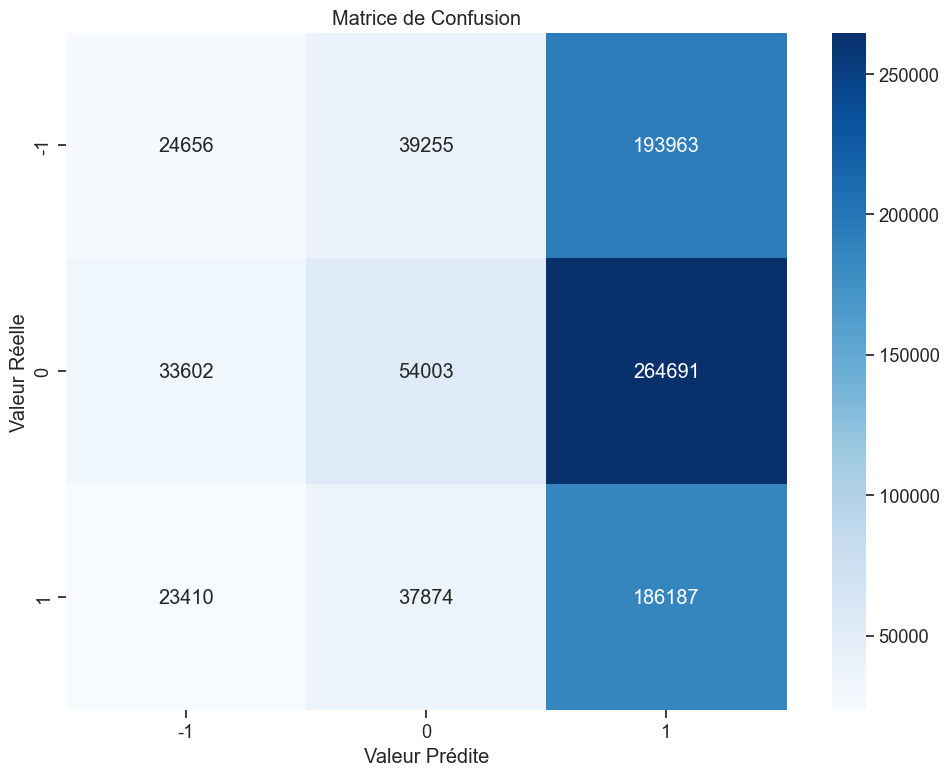

In [10]:
print("\n\n--- Évaluation finale des modèles avec features optimisées ---")
inverse_mapping = {0: -1, 1: 0, 2: 1}
# 6.1 Identification de la meilleure méthode de sélection
best_method = None
best_score = 0

for method, results in all_results.items():
    if 'best_score' in results and results['best_score'] > best_score:
        best_score = results['best_score']
        best_method = method

if best_method:
    print(f"\nLa meilleure méthode de sélection est: {best_method} avec un score de {best_score:.4f}")
    best_features = all_results[best_method]['optimal_features']
    print(f"Nombre de features optimales: {len(best_features)}")
    print("Top 10 des features optimales:")
    print(best_features[:10])
    
    # 6.2 Test final sur le dataset de test avec les features optimales
    X_train_selected = X[best_features]
    
    # Préparation des données de test
    X_test = x_test_ffbf_with_feature.drop(['ID', 'reod'], axis=1, errors='ignore')
    X_test_normalized = normalize_rendements_by_row(X_test)
    X_test_selected = X_test_normalized[best_features]
    
    # Remappage des classes pour le modèle final
    y_train_mapped = y.map(mapping)
    y_test_mapped = y_test_ffbf_with_features.map(mapping)
    
    # Entraînement du modèle final
    print("\nEntraînement du modèle final avec les features optimales...")
    final_model = Pipeline([
        ('scaler', StandardScaler()),
        ('model', xgboost_factory())
    ])
    
    final_model.fit(X_train_selected, y_train_mapped)
    
    # Prédiction sur le dataset de test
    y_pred_mapped = final_model.predict(X_test_selected)
    
    # Remappage inverse pour l'évaluation
    y_pred = np.array([inverse_mapping[val] for val in y_pred_mapped])
    
    # Évaluation des performances
    accuracy = accuracy_score(y_test_ffbf_with_features, y_pred)
    print(f"\nPerformance finale sur le dataset de test:")
    print(f"Accuracy: {accuracy:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test_ffbf_with_features, y_pred))
    
    # Affichage de la matrice de confusion
    conf_matrix = confusion_matrix(y_test_ffbf_with_features, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
    plt.title('Matrice de Confusion')
    plt.xlabel('Valeur Prédite')
    plt.ylabel('Valeur Réelle')
    plt.tight_layout()
    plt.show()
else:
    print("Aucune méthode de sélection n'a généré de résultat d'optimisation valide.")
    # Créer un ensemble de features par défaut si rien n'a fonctionné
    print("Utilisation d'un ensemble de features par défaut...")
    
    # Utiliser les features les plus corrélées avec la cible
    correlations = X.corrwith(y).abs().sort_values(ascending=False)
    best_features = correlations.head(20).index.tolist()
    
    print(f"Features par défaut (top corrélations): {best_features[:10]}")

In [11]:
X_train_selected 

,day,r_roll_std_10,r_roll_std_20,r_std,r_pos_sum,equity,r_neg_sum,r_roll_std_5,r_min,r_max,...,r47,r43,r19,r0,r42,r31,r11,r34,r44,r1
0,272,13.660327,11.110787,18.820373,411.59,107,-303.83,17.927125,-45.87,48.22,...,-0.108032,-0.364669,0.914264,-0.626619,0.020552,-0.623431,1.166650,0.020552,-1.007058,-0.108032
1,323,19.591007,23.371939,24.011006,402.29,1063,-523.80,13.011273,-68.08,53.61,...,-0.303917,-0.169812,-0.100677,2.171614,-2.739883,0.291643,-1.279303,0.127968,0.161703,0.095483
2,123,21.856480,29.044273,36.138157,531.34,1465,-939.58,27.909429,-123.84,64.52,...,-0.383178,0.064825,0.213144,-3.213705,-0.378751,0.213144,0.803102,1.106660,-0.380134,-2.974069
3,343,4.357074,5.405468,8.930408,122.82,1279,-202.09,5.385919,-35.04,17.54,...,-0.189727,0.077898,-0.903020,-2.845821,0.167480,-0.011684,0.523566,0.167480,0.257061,0.700490
4,212,6.337378,6.772368,10.576211,193.74,185,-204.49,6.526255,-30.81,26.37,...,0.019178,-0.397796,-0.396850,0.019178,-0.189782,0.019178,0.019178,1.273881,0.019178,-2.880726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730779,297,9.140075,10.140861,18.278016,245.00,123,-333.02,12.562971,-70.34,74.24,...,0.215601,-0.500013,-1.303164,0.307514,1.087687,1.085498,1.725612,0.462892,0.184416,0.090861
730780,16,13.154854,16.766903,31.483810,347.99,1501,-487.38,14.336620,-183.49,46.24,...,0.083535,0.083535,0.083535,0.083535,0.927778,0.083535,0.083535,-0.964623,0.293802,-5.744540
730781,166,6.171472,8.701956,10.283202,228.12,1231,-169.84,8.855842,-22.64,37.02,...,-0.213904,0.177024,1.170878,3.493112,0.070054,-1.593825,-1.067724,-0.621365,-0.425901,0.177997
730782,297,15.282446,14.206918,16.085686,374.09,747,-304.66,15.836735,-35.61,34.45,...,0.004352,-1.365189,0.640943,2.060217,0.861014,-0.336324,1.291832,-0.251777,-0.424601,0.857284


In [12]:
X_test_selected

,day,r_roll_std_10,r_roll_std_20,r_std,r_pos_sum,equity,r_neg_sum,r_roll_std_5,r_min,r_max,...,r47,r43,r19,r0,r42,r31,r11,r34,r44,r1
0,1000384,56.727141,130.193370,167.828946,2085.49,1000064,-4432.81,38.593068,-533.83,216.52,...,0.405407,-0.431397,-2.103040,0.735744,1.186023,1.527383,0.389975,0.392954,0.441575,0.106770
1,1000148,43.135263,38.915390,73.212373,1417.49,1000841,-1252.71,59.457366,-321.77,110.30,...,-0.334903,-0.209241,-0.220168,-4.437488,-0.111990,0.128270,0.886885,-0.462750,-0.021568,-2.480989
2,1000441,16.323341,14.405700,18.905660,183.50,1000380,-565.57,8.665392,-72.68,38.58,...,0.561148,1.098553,-0.325359,-2.366547,-0.335409,-0.687685,-0.676048,1.632784,-0.156098,-0.654361
3,1000059,21.897086,33.669799,38.470760,491.79,1001843,-793.86,27.830326,-169.49,105.87,...,0.908208,-0.104510,-0.099571,-4.257534,-0.607489,-0.101390,-0.223301,0.148150,-0.104510,0.396910
4,1000336,3.685469,6.046200,15.774973,294.63,1001783,-289.45,4.040714,-46.19,32.82,...,0.344360,-0.239477,1.558942,-2.934251,-0.161505,0.111079,-1.377355,0.111079,-0.122836,2.033111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857636,1000001,7.177713,7.867518,13.759822,357.90,1001031,-137.92,9.798861,-32.85,63.96,...,-0.146845,-0.198445,0.008680,-0.301644,-1.282034,0.574094,0.474529,-0.919384,0.524675,1.944025
857637,1000125,8.922531,11.802368,21.610005,476.64,1001131,-350.41,10.604194,-67.41,67.87,...,-0.522522,-0.168982,-0.288371,-0.110213,-0.640060,-0.169445,0.483494,0.684789,0.125326,3.030462
857638,1000314,7.536482,8.675428,18.818911,343.50,1000333,-288.04,7.458051,-65.02,76.29,...,-0.055604,0.016663,0.673981,3.998297,-0.055604,0.089994,-0.928662,0.381190,-0.127872,-3.510640
857639,1000247,8.122167,6.637246,15.066410,229.86,1000348,-283.18,6.796108,-73.66,37.11,...,0.066774,-0.462218,-0.815985,-4.822248,0.243325,0.066774,0.595765,0.243325,0.772317,2.529869




--- Ajout de features financières avancées ---
Ajout de features financières avancées aux données d'entraînement...
Nouvelles features ajoutées: 10
Liste des nouvelles features: ['volatility_5', 'volatility_10', 'volatility_20', 'sharpe_ratio', 'r_skewness', 'r_kurtosis', 'rsi_5', 'rsi_14', 'macd', 'pos_neg_ratio']

Top correlations des nouvelles features financières:
rsi_14           0.006886
rsi_5            0.002910
r_kurtosis       0.001424
pos_neg_ratio    0.000514
macd            -0.005593
r_skewness      -0.006067
sharpe_ratio    -0.007692
volatility_20   -0.009325
volatility_5    -0.009581
volatility_10   -0.015517
dtype: float64


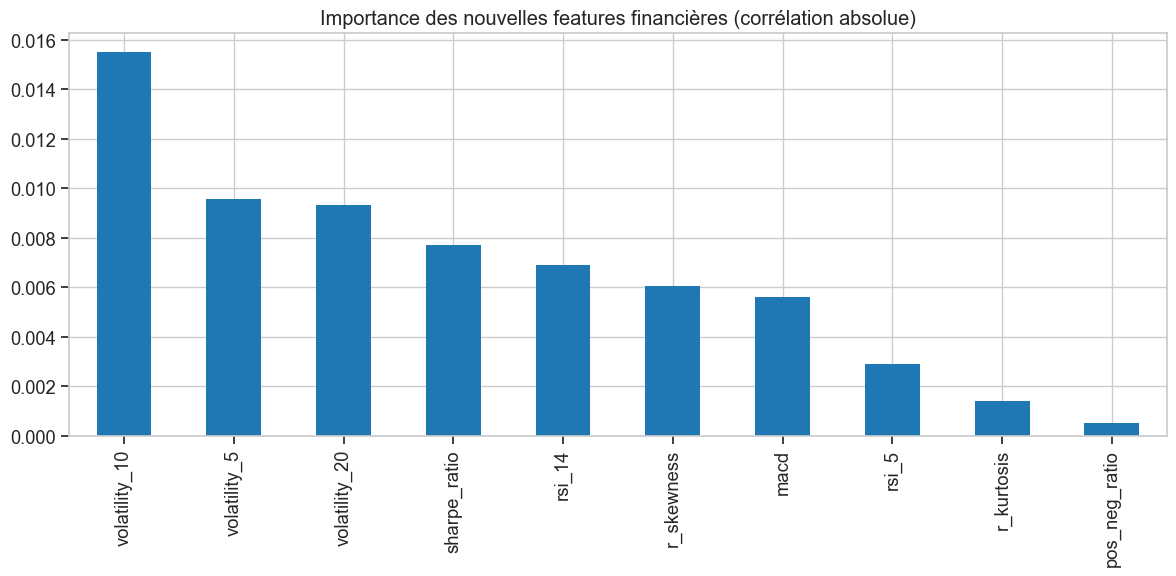


Test du modèle avec l'ajout des features financières...

Performance finale avec features financières avancées:
Accuracy: 0.3094
Amélioration: 0.0006 (0.06%)

Classification Report:
              precision    recall  f1-score   support

          -1       0.30      0.13      0.18    257874
           0       0.41      0.16      0.23    352296
           1       0.29      0.72      0.41    247471

    accuracy                           0.31    857641
   macro avg       0.33      0.33      0.27    857641
weighted avg       0.34      0.31      0.27    857641



In [14]:
# =========================================
# Section 7: Ajout de features financières avancées
# =========================================
print("\n\n--- Ajout de features financières avancées ---")
# 7.2 Application des nouvelles features financières
print("Ajout de features financières avancées aux données d'entraînement...")
X_train_enriched = add_financial_features(x_train_ffbf_with_feature_normalized)
new_features = [col for col in X_train_enriched.columns if col not in x_train_ffbf_with_feature_normalized.columns]
print(f"Nouvelles features ajoutées: {len(new_features)}")
print(f"Liste des nouvelles features: {new_features}")

# 7.3 Analyse des nouvelles features
if new_features:
    # Analyse des corrélations des nouvelles features avec la cible
    financial_corr = X_train_enriched[new_features].corrwith(y_train_ffbf_with_features)
    financial_corr = financial_corr.sort_values(ascending=False)
    
    print("\nTop correlations des nouvelles features financières:")
    print(financial_corr)
    
    plt.figure(figsize=(12, 6))
    financial_corr.abs().sort_values(ascending=False).plot(kind='bar')
    plt.title('Importance des nouvelles features financières (corrélation absolue)')
    plt.tight_layout()
    plt.show()
# 7.4 Test du modèle avec les features financières
print("\nTest du modèle avec l'ajout des features financières...")
X_train_complete = X_train_enriched.drop(['ID', 'reod'], axis=1, errors='ignore')

# Utilisation des features optimales précédentes + nouvelles features financières
combined_features = list(best_features) + [f for f in new_features if f not in best_features]
X_train_final = X_train_complete[combined_features]

# Préparation des données de test avec les nouvelles features
X_test_normalized = normalize_rendements_by_row(x_test_ffbf_with_feature)
X_test_enriched = add_financial_features(X_test_normalized)
X_test_final = X_test_enriched[combined_features]

# Rappel du mapping pour les classes
mapping = {-1: 0, 0: 1, 1: 2}
inverse_mapping = {0: -1, 1: 0, 2: 1}

# Remapper les étiquettes
y_mapped = y.map(mapping)
y_test_mapped = y_test_ffbf_with_features.map(mapping)

# Entraînement et évaluation du modèle final
final_model_enriched = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgboost_factory())
])

final_model_enriched.fit(X_train_final, y_mapped)
y_pred_enriched_mapped = final_model_enriched.predict(X_test_final)

# Remapper les prédictions à leur format original
y_pred_enriched = np.array([inverse_mapping[val] for val in y_pred_enriched_mapped])

# Évaluation des performances
accuracy_enriched = accuracy_score(y_test_ffbf_with_features, y_pred_enriched)
print(f"\nPerformance finale avec features financières avancées:")
print(f"Accuracy: {accuracy_enriched:.4f}")
if 'accuracy' in locals():
    improvement = accuracy_enriched - accuracy
    print(f"Amélioration: {improvement:.4f} ({improvement*100:.2f}%)")

print("\nClassification Report:")
print(classification_report(y_test_ffbf_with_features, y_pred_enriched))


In [ ]:
# =========================================
# Section 8: Conclusion et résumé
# =========================================
print("\n\n--- Résumé des résultats ---")

# 8.1 Récapitulatif des performances
print("\nRécapitulatif des performances des modèles:")
for i, result in enumerate(imputation_results):
    print(f"{i+1}. {result['dataset']} - {result['model']} - Accuracy: {result['accuracy']:.4f}")

# 8.2 Meilleure méthode de sélection de features
if best_method:
    print(f"\nMeilleure méthode de sélection: {best_method}")
    print(f"Nombre optimal de features: {all_results[best_method]['optimal_n_features']}")
    print(f"Score optimal: {all_results[best_method]['best_score']:.4f}")

# 8.3 Résultats finaux
if 'accuracy' in locals() and 'accuracy_enriched' in locals():
    print("\nRésultats finaux:")
    print(f"Modèle avec features optimisées: {accuracy:.4f}")
    print(f"Modèle avec features financières avancées: {accuracy_enriched:.4f}")
    print(f"Amélioration finale: {(accuracy_enriched - accuracy)*100:.2f}%")

print("\nAnalyse et optimisation complètes !")